In [1]:
import streamlit as st
import pandas as pd
import numpy as np
import yaml
import pyodbc
from market_growth_analysis.etl.stagging import *
import pandas as pd
import numpy as np
import pyodbc
import sqlalchemy
from sqlalchemy import create_engine
import sys
import pandas as pd
import matplotlib.pyplot as plt

# sys.path.append('../conf') 
# Load the YAML file
with open('../../conf/global.yml', 'r') as f:
    columns = yaml.safe_load(f)

# Load the YAML file
with open('../../conf/local.yml', 'r') as f:
    credentials = yaml.safe_load(f)


# Get credentials
driver = credentials['warehouse_db']['driver']
server = credentials['warehouse_db']['server']
database = credentials['warehouse_db']['database']
trusted = credentials['warehouse_db']['trusted_connection']
user = credentials['warehouse_db']['user']
password = credentials['warehouse_db']['password']

# Create connection db
conn = pyodbc.connect('Driver={SQL Server};'
                      f'Server={server};'
                      f'Database={database};'
                      'Trusted_Connection=yes;')
cursor = conn.cursor()

In [2]:
# Get data
join_tables_query = '''
select *
from DIM_COMPANY dim
join FACT_BALANCE_SHEET bs on bs.ticker = dim.ticker
join FACT_CASH_FLOW_STATEMENT cfs on cfs.PK = bs.PK
join FACT_INCOME_STATEMENT fis on fis.PK = bs.PK
join FACT_PRICES fp on fp.PK = bs.PK
join FACT_RATIOS fr on fr.PK = bs.PK
'''
data = pd.read_sql(join_tables_query, conn)
# drop duplicated columns
data = data.T.drop_duplicates().T
data['Date'] = pd.to_datetime(data['Date'], format="%Y/%m/%d").dt.strftime("%Y/%m/%d")


C:\Users\germa\AppData\Local\Temp/ipykernel_15476/764186177.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(join_tables_query, conn)


In [3]:
data.columns

Index(['ticker', 'company_full_name', 'country', 'industry', 'sector', 'PK',
       'Date', 'Cash On Hand', 'Receivables', 'Inventory', 'Pre-Paid Expenses',
       'Other Current Assets', 'Total Current Assets',
       'Property, Plant, And Equipment', 'Long-Term Investments',
       'Goodwill And Intangible Assets', 'Other Long-Term Assets',
       'Total Long-Term Assets', 'Total Assets', 'Total Current Liabilities',
       'Long Term Debt', 'Other Non-Current Liabilities',
       'Total Long Term Liabilities', 'Total Liabilities', 'Common Stock Net',
       'Retained Earnings (Accumulated Deficit)', 'Comprehensive Income',
       'Other Share Holders Equity', 'Share Holder Equity',
       'Total Liabilities And Share Holders Equity', 'Net Income/Loss',
       'Total Depreciation And Amortization - Cash Flow',
       'Other Non-Cash Items', 'Total Non-Cash Items',
       'Change In Accounts Receivable', 'Change In Inventories',
       'Change In Accounts Payable', 'Change In Assets/L

In [4]:
data['industry'].value_counts()

Medical - Biomedical and Genetics        3573
Medical - Drug Manufacturing             1682
Technology Services                      1232
Banks - Northeast                        1199
REIT - Other Equity Trusts               1165
                                         ... 
Electronics - Military Systems             11
Nanotechnology Equipment and Services      11
Retail - Mail Order & Direct                9
Printing & Trade Machinery                  8
Periodical Publishing                       2
Name: industry, Length: 252, dtype: int64

In [5]:
columns_to_study = columns['columns_prices'] + columns['columns_ratios'] + columns['column_id']

In [6]:
data_filtered_industry = data[(data['industry'] == 'Medical - Biomedical and Genetics')&(data['country'] == 'United States')]

In [7]:
data_to_study = data_filtered_industry[columns_to_study]

In [8]:
data_to_study = data_to_study.dropna(subset='Growth +5')

In [9]:
data_to_study_filled = data_to_study.fillna(value=0)

In [11]:
data_to_study_filled.columns

Index(['longevity', 'Close', 'Volume', 'Growth -1', 'Growth +1', 'Growth +5',
       'Growth -10', 'Growth -5', 'Enterprise Value (EV)', 'EV / Revenue',
       'EV / EBITDA', 'EV / EBIT', 'EV / Invested Capital',
       'Free Cash Flow (FCF)', 'EV / Free Cash Flow', 'P/E', 'P/S', 'P/CF',
       'PK', 'ticker', 'Date'],
      dtype='object')

In [12]:
columns_to_drop = ['Growth +1', 'Date', 'ticker', 'Close', 'Volume', 'longevity', 'Enterprise Value (EV)', 'Free Cash Flow (FCF)']
data_to_study_filled_drop = data_to_study_filled.drop(columns=columns_to_drop)
data_to_study_filled_drop = data_to_study_filled_drop.set_index(keys='PK')

In [13]:
data_to_study_filled_drop['Growth +5']*100

PK
7926     -98.332906
7927     -97.034138
7928     -98.189329
1942     352.938056
1936     854.766761
            ...    
5811     -13.074047
6229     -60.256412
816      -69.358974
44047     16.013073
32506    -56.666666
Name: Growth +5, Length: 1098, dtype: float64

In [14]:
(data_to_study_filled_drop['Growth +5']*100).describe()

count    1098.000000
mean       63.226037
std       316.903970
min       -99.994222
25%       -90.472498
50%       -35.207060
75%        71.094210
max      2988.210578
Name: Growth +5, dtype: float64

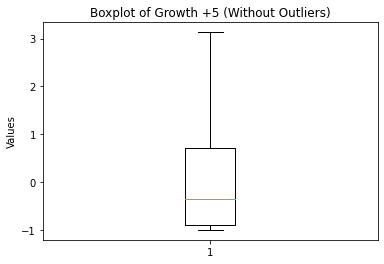

In [15]:
import matplotlib.pyplot as plt

# Assuming data_to_study_filled_drop is your DataFrame
plt.boxplot(data_to_study_filled_drop['Growth +5'], showfliers=False)
plt.title('Boxplot of Growth +5 (Without Outliers)')
plt.ylabel('Values')
plt.show()


In [16]:
# data_to_study_filled_drop['target'] = data_to_study_filled_drop['Growth +5'] > 0
# data_to_study_filled_drop['target'] = data_to_study_filled_drop['target'].astype(int)

import pandas as pd
import numpy as np

# Assuming you have a DataFrame named data_to_study_final
data_to_study_filled_drop['target'] = np.where(data_to_study_filled_drop['Growth +5'] < 0, 0, 
                        np.where(data_to_study_filled_drop['Growth +5'] <= data_to_study_filled_drop['Growth +5'].quantile(0.9), 1, 2))



In [17]:
data_to_study_final = data_to_study_filled_drop.drop(columns='Growth +5')

In [18]:
data_to_study_final.shape

(1098, 12)

In [19]:
data_to_study_final['target'].value_counts()

0    679
1    309
2    110
Name: target, dtype: int64

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
X = data_to_study_final.drop('target', axis=1)  # Features
y = data_to_study_final['target']  # Target variable


In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import precision_score, make_scorer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define the SVM parameter grid to search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'sigmoid'],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
    # 'degree': [2, 3, 4, 5],
    'class_weight': ['balanced']
}

# Create a custom scoring function for precision
scoring = make_scorer(precision_score, average='weighted')

# Create the SVM classifier
svm_classifier = SVC()

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=svm_classifier,
    param_distributions=param_grid,
    scoring=scoring,
    cv=5,  # Number of cross-validation folds
    n_iter=50,  # Number of random combinations to try
    verbose=1,
    n_jobs=-1  # Use all available CPU cores for parallel processing
)

# Fit the RandomizedSearchCV to the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding precision score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Precision Score:", random_search.best_score_)

# Get the best model from the search
best_svm_classifier = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_svm_classifier.predict(X_test)

# Calculate precision on the test set
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision on Test Set:", precision)


c:\Users\germa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 30 is smaller than n_iter=50. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 0.01, 'class_weight': 'balanced', 'C': 0.1}
Best Precision Score: 0.6091262745946606
Precision on Test Set: 0.8204545454545453


In [26]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb

# Assuming you have already prepared X_train, X_test, y_train, and y_test

# Create and specify the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Create the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_classes=3, random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='precision', cv=5, n_jobs=-1)

# Fit the GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Get the best model from the search
best_xgb_classifier = grid_search.best_estimator_


[20:54:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_classes" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:54:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best Accuracy: nan


c:\Users\germa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan 

C:\Users\germa\AppData\Local\Temp/ipykernel_15476/600586410.py:15: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.barh(range(top_n), feature_importance_df['Importance'][:top_n], align='center')
C:\Users\germa\AppData\Local\Temp/ipykernel_15476/600586410.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.yticks(range(top_n), feature_importance_df['Feature'][:top_n])


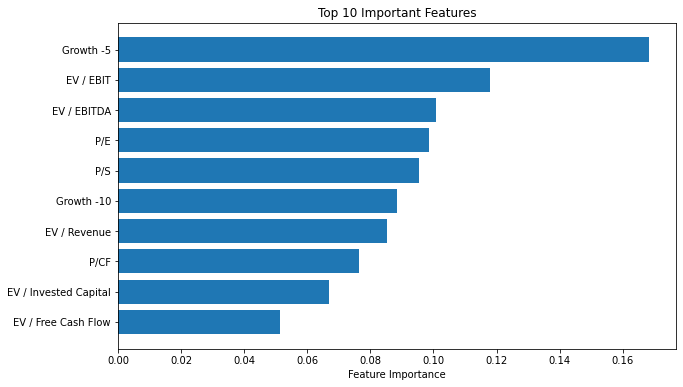

In [27]:
import matplotlib.pyplot as plt

# Get feature importances from the best model
feature_importances = best_xgb_classifier.feature_importances_

# Create a DataFrame to display feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top N important features
top_n = 10  # Change this value to display more or fewer features
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), feature_importance_df['Importance'][:top_n], align='center')
plt.yticks(range(top_n), feature_importance_df['Feature'][:top_n])
plt.xlabel('Feature Importance')
plt.title('Top {} Important Features'.format(top_n))
plt.gca().invert_yaxis()
plt.show()


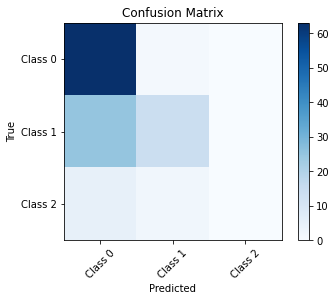

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.68      0.98      0.80        64
     Class 1       0.82      0.36      0.50        39
     Class 2       0.00      0.00      0.00         7

    accuracy                           0.70       110
   macro avg       0.50      0.45      0.43       110
weighted avg       0.69      0.70      0.64       110



c:\Users\germa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\germa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\germa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have already prepared X_test and y_test and have the best_xgb_classifier from the previous code

# Make predictions on the test set
y_pred = best_xgb_classifier.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(range(len(set(y_test))), ['Class 0', 'Class 1', 'Class 2'], rotation=45)
plt.yticks(range(len(set(y_test))), ['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Generate a classification report for more detailed metrics
classification_rep = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1', 'Class 2'])
print('Classification Report:\n', classification_rep)
